In [90]:
from General import functies as functies
from General import classes as classes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [91]:
#code geript van de geluidsproef
def X_tractor(inhoud, previous = None): #extraheert effectief nuttige data uit die txt-files


    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken

    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    
    invals = [amplitude, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

def uncook_data(Tpart, Vpart, V_part_fout):

    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

#das Model des Elektrofelds
def model_E(Zeit, Festeparameters, Fitparameters):
    
    phase, amplitude, Ruhe, omega, q, x0 = Fitparameters
    epsilon_nul = 8.85e-12
    Abstand = x0 + amplitude * np.sin(omega*Zeit + phase)
    E = q/(4*np.pi*epsilon_nul) * (1/Abstand)**2 + Ruhe
    return E

3.8553386833890952 omega_inval
31.41592653589793
[[-1.552214234323962, -1.5522317991131898], [0.26902578975470093, 0.26902578974787866], [-119.18121827341453, -1396.863281255487], [1.965381068625417, 3.889470457914738], [9.999999999822224e-09, 1.616654894433905e-08], [0.250007657772271, 0.5000000000044441]]
phi heeft als waarde: -1.5522 + -8.7985e-06 - -8.7663e-06 met 68% betrouwbaarheidsinterval: [-1.5522, -1.5522] 
A heeft als waarde: 0.26903 + 4.7534e-07 - -4.7535e-07 met 68% betrouwbaarheidsinterval: [0.26903, 0.26903] 
C_0 heeft als waarde: -1396.9 + -5.487e-09 - -1277.7 met 68% betrouwbaarheidsinterval: [-119.18, -1396.9] 
omega heeft als waarde: 3.8895 + 1.3083e-06 - 1.9241 met 68% betrouwbaarheidsinterval: [1.9654, 3.8895] 
q heeft als waarde: 1e-08 + 6.1665e-09 - 1.7776e-19 met 68% betrouwbaarheidsinterval: [1e-08, 1.6167e-08] 
x0 heeft als waarde: 0.5 + 4.4441e-12 - 0.24999 met 68% betrouwbaarheidsinterval: [0.25001, 0.5] 
De p-waarde voor de hypothese test dat het model zinv

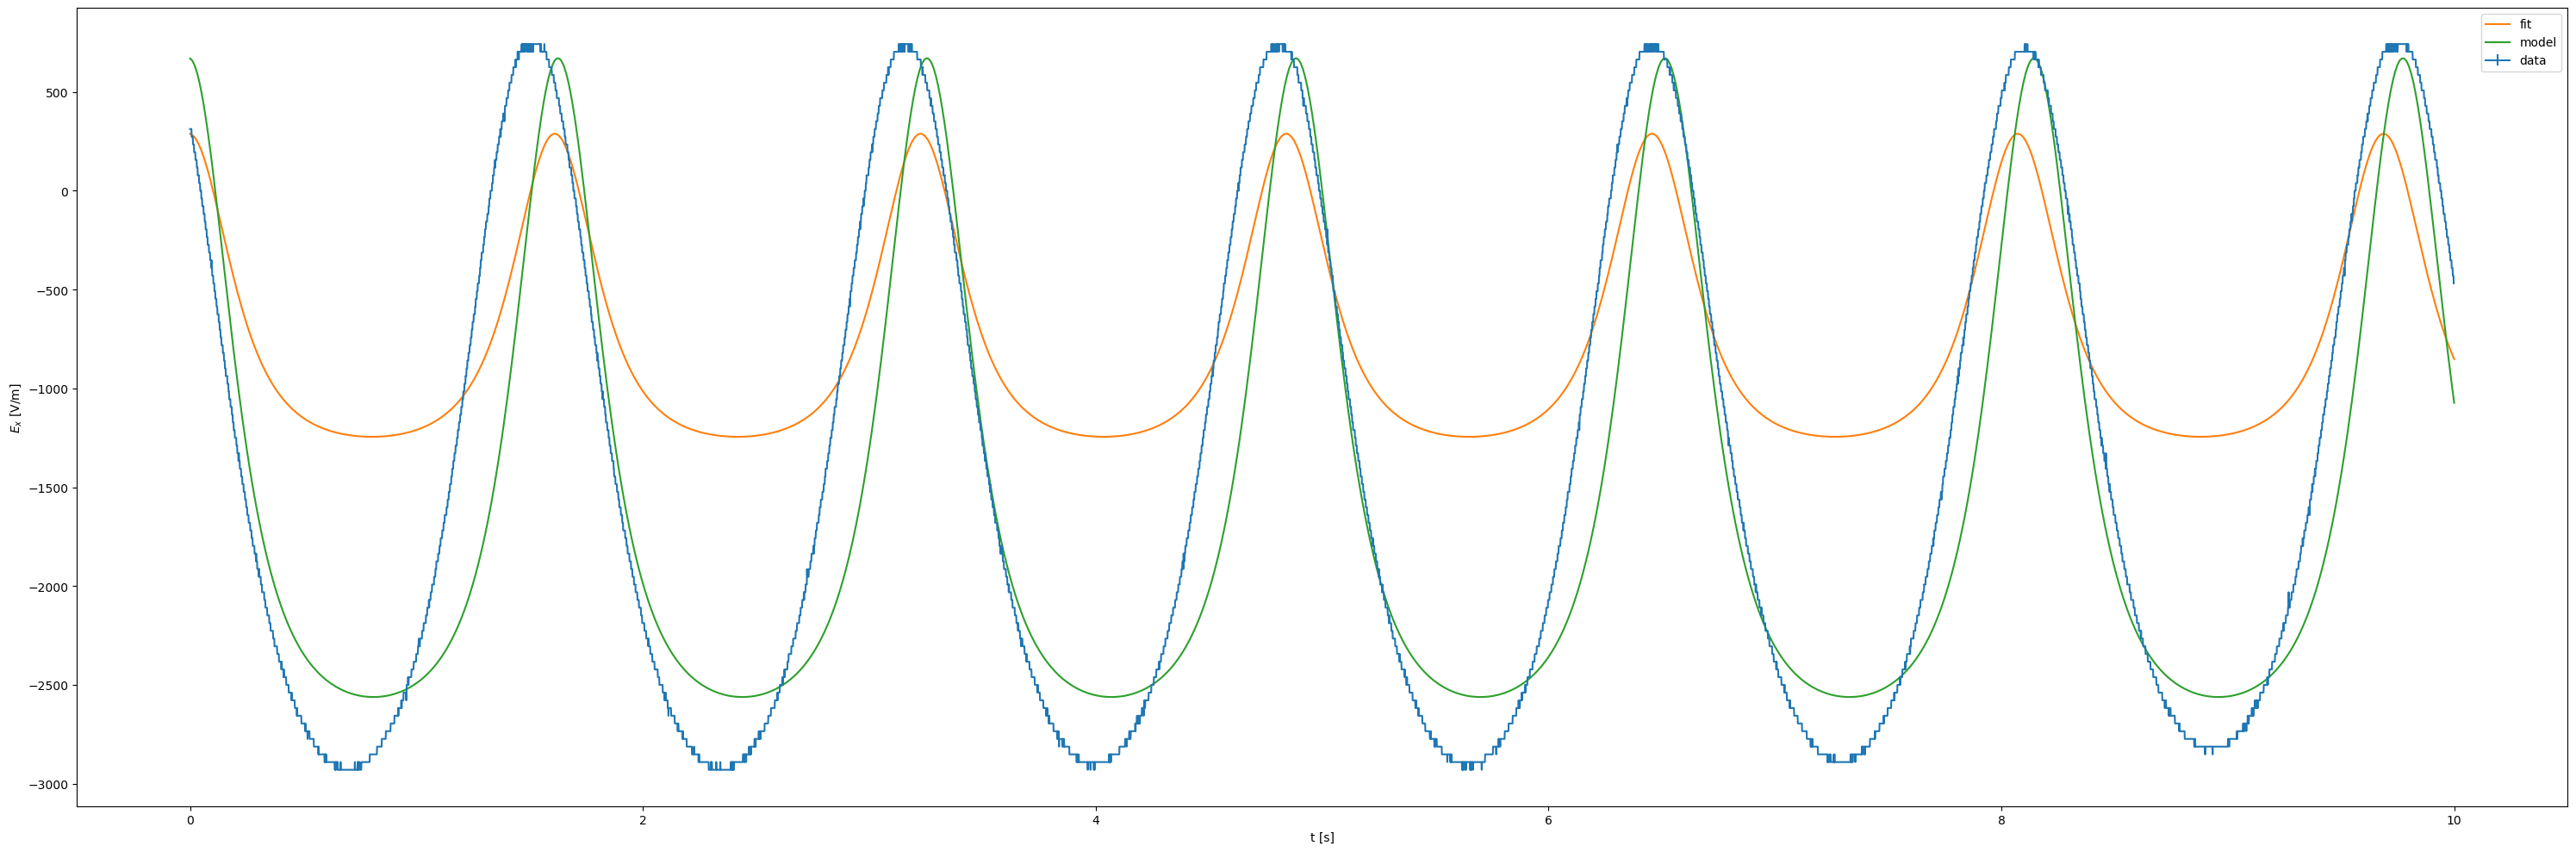

In [92]:
def model_proef_1(Zeit, params):
    return model_E(Zeit, [57e-2], params)

pad = 'Vrije proef/m1-1.txt'
file = open(pad, 'rt')

T, V, eenheid, invals = X_tractor(file.read()) #ACHTUNG: Spannung aus Millivolt
V_err = np.full(np.shape(V), 1) #Ein Error von einem Millivolt
T, V, V_err = uncook_data(T, V, V_err)

E = V/10 #E in V/m (want *100 voor V -> V/m en /1000 voor mV -> V)
E_err = V_err/10
file.close()

#die gemessen Parametern
Kordelänge = 66.0e-2
g = 9.81
omega = np.sqrt(g/Kordelänge)
print(omega, 'omega_inval')
q = 1e-8 #Coulomb

#fast fourrier transform voor wat beginvoorwaarden
frequentielijst = np.fft.fft(E)
modulus = np.abs(frequentielijst)
C_0 = np.real(frequentielijst[0]) * (T[1] - T[0])
eigenfreq = 2*np.pi * np.argmax(modulus[1:]) #Ca ne marche pas donc on ne l'utilise pas
print(eigenfreq)


outp = functies.fit(['phi', 'A', 'C_0', 'omega', 'q', 'x0'], model_proef_1, lambda x,y: [-np.pi/2, 0.3, C_0, omega, q, 57e-2], T, E, E_err, 
                    bounds = [(-np.pi, np.pi), (0,0.5), (C_0-10, C_0+10), (omega*3/4, omega*5/4), (1e-10, 1e-8), (0.5,0.7)], detailed_logs=False)
print(outp)
fitparams = [param[0] for param in outp]
fig, ax = plt.subplots(1,1, figsize = (30,10))
ax.errorbar(T, V, yerr = E_err, label = 'data', fmt = '')
Zeitlinspace = np.linspace(0,10,1000)
ax.plot(Zeitlinspace, model_proef_1(Zeitlinspace, fitparams), label = 'fit')
ax.plot(Zeitlinspace, model_proef_1(Zeitlinspace, [-1.552214234, 0.3, -2906, omega, q*2.9, 57e-2]), label = 'model')
#ax.plot(Zeitlinspace, 1000*np.sin(Zeitlinspace*omega+np.pi/2)-1500, label = 'regular sine wave')
ax.set_ylabel('$E_x$ [V/m]')
ax.set_xlabel('t [s]')
ax.legend()
plt.tight_layout()
plt.show()